# Reproducibility Project - Deep Learning (CS4240) 2020/2021

Group Number: 20

Student 1: Stan Zwinkels

Student 2: Ted de Vries Lentsch

Date: 16 April 2021

## Import necessary libraries

In [1]:
# standard libraries
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import time

# widgets
import ipywidgets

# data processing
from skimage.transform import resize

# "for loop" information
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# Additional setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

## Determine device

In [2]:
# check if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# print device
print('The device is: {}'.format(device))

The device is: cuda:0


## Settings
The training of the detection network consists of 4 steps. In the first step, the Region Proposal Network (RPN) is trained and the first 10 layers of the used VVG16 part are frozen. In the second step, Fast R-CNN is trained by using the proposals created during step one. In the third step, the RPN is trained again but the VVG16 part of the Fast R-CNN from step two is used and this part is frozen such that the RPN and Fast R-CNN share the VGG16 part. In the fourth step, Fast R-CNN is trained again with the VVG16 part from the second step frozen to tune the unique layers of the Fast R-CNN.

In [3]:
do_step1 = False
do_step2 = False
do_step3 = False
do_step4 = False

## 1. Explore dataset
The [dataset](http://data.acfr.usyd.edu.au/ag/treecrops/2016-multifruit/) acfr-fruit-dataset of the paper [Deep Fruit Detection in Orchards](https://arxiv.org/abs/1610.03677) contains three different fruits: mangoes, almonds and apples. We use the apple images.

The directory tree of the dataset acfr-fruit-dataset is shown below.

```
acfr-fruit-dataset
├── almonds
│   ├── annotations
│   ├── images
│   ├── labelmap.json
│   └── sets
│       ├── all.txt
│       ├── test.txt
│       ├── train.txt
│       ├── train_val.txt
│       └── val.txt
├── apples
│   ├── annotations
│   ├── images
│   ├── labelmap.json
│   ├── segmentations
│   └── sets
│       ├── all.txt
│       ├── test.txt
│       ├── train.txt
│       ├── train_val.txt
│       └── val.txt
├── mangoes
│   ├── annotations
│   ├── images
│   ├── labelmap.json
│   └── sets
│       ├── all.txt
│       ├── test.txt
│       ├── train.txt
│       ├── train_val.txt
│       └── val.txt
└── readme.txt
```

We only need the images, annotations and sets of the apples and therefore we created the folder Dataset. The directory tree of this folder is shown below. The folder has also been added to this GitHub repository and can be downloaded to run this notebook directly. I do not own this dataset and use it only for reproducing the paper. For questions about the dataset, I refer to the authors of the paper [Deep Fruit Detection in Orchards](https://arxiv.org/abs/1610.03677).

```
Dataset
├── apples
│   ├── annotations
│   ├── images
│   └── sets
│       ├── all.txt
│       ├── test.txt
│       ├── train.txt
│       ├── train_val.txt
│       └── val.txt
└── readme.txt
```

### 1.1. Load the data
The apple images were divided into a training, validation, and test set by the authors of the paper. The paper [Deep Fruit Detection in Orchards](https://arxiv.org/abs/1610.03677) states that some images from the training set do not contain apples and that these images should be removed. In table 1 of the paper, it is stated that there are 729 training images with at least one apple, however, from the code below it follows that the training set contains 846 images with at least one apple. So the training set that is used has 117 more images than it should have according to the paper.

In the code below the images and annotations of the training, validation, and test set are loaded. The original annotations contain rows with [index, x_center, y_center, radius, 1], but this is converted to [x_min, x_max, y_min, y_max] for convenience. The training images that do not contain an apple are removed and the size of each set is printed.

In [4]:
# construct path to set info
path_sets  = 'Dataset\\apples\\sets'
path_train = '{}\\train.txt'.format(path_sets)
path_val   = '{}\\val.txt'.format(path_sets)
path_test  = '{}\\test.txt'.format(path_sets)

# get filenames
filenames_train = sorted(np.loadtxt(path_train, dtype=str))
filenames_val   = sorted(np.loadtxt(path_val, dtype=str))
filenames_test  = sorted(np.loadtxt(path_test, dtype=str))

# load images
path_img = 'Dataset\\apples\\images' 
Is_train = [plt.imread('{}\\{}.png'.format(path_img, name)) for name in filenames_train] 
Is_val   = [plt.imread('{}\\{}.png'.format(path_img, name)) for name in filenames_val] 
Is_test  = [plt.imread('{}\\{}.png'.format(path_img, name)) for name in filenames_test] 

# load annotations
path_annot   = 'Dataset\\apples\\annotations' 
annots_train = [pd.read_csv('{}\\{}.csv'.format(path_annot, name), sep=',', header=0).to_numpy() for name in filenames_train] 
annots_val   = [pd.read_csv('{}\\{}.csv'.format(path_annot, name), sep=',', header=0).to_numpy() for name in filenames_val] 
annots_test  = [pd.read_csv('{}\\{}.csv'.format(path_annot, name), sep=',', header=0).to_numpy() for name in filenames_test]

# convert annotations from [index, x_center, y_center, radius, 1] to [x_min, x_max, y_min, y_max]
annots_train = [np.vstack((ar[:,1]-ar[:,3], ar[:,1]+ar[:,3], ar[:,2]-ar[:,3], ar[:,2]+ar[:,3])).T for ar in annots_train]
annots_val = [np.vstack((ar[:,1]-ar[:,3], ar[:,1]+ar[:,3], ar[:,2]-ar[:,3], ar[:,2]+ar[:,3])).T for ar in annots_val]
annots_test = [np.vstack((ar[:,1]-ar[:,3], ar[:,1]+ar[:,3], ar[:,2]-ar[:,3], ar[:,2]+ar[:,3])).T for ar in annots_test]

# remove images with zero apples
remove_ids = [i for i, apple_matrix in enumerate(annots_train) if len(apple_matrix)==0]
for index in sorted(remove_ids, reverse=True):
    del Is_train[index]
    del annots_train[index]

# print summary
print('Training dataset has {} images and {} annotations.'.format(len(Is_train), len(annots_train)))
print('Validation dataset has {} images and {} annotations.'.format(len(Is_val), len(annots_val)))
print('Test dataset has {} images and {} annotations.'.format(len(Is_test), len(annots_test)))

Training dataset has 846 images and 846 annotations.
Validation dataset has 112 images and 112 annotations.
Test dataset has 112 images and 112 annotations.


### 1.2. Images
Below, the images from the training set are displayed with an interactive widget. The size of every image is (H, W, RGB_channels) = (202, 308, 3).

In [5]:
def plot_img(I):
    plt.figure(figsize=(10, 10))
    plt.imshow(I, zorder=-10)
    plt.xlabel('Width of image (pixels)', fontsize=20)
    plt.ylabel('Height of image (pixels)', fontsize=20)
    plt.xticks(np.linspace(0, 300, 13), fontsize=16)
    plt.yticks(np.linspace(0, 200, 9), fontsize=16)
    plt.xlim(0, 308)
    plt.ylim(202, 0)
    plt.show()

# create interactive widget
ipywidgets.interact(lambda idx: plot_img(Is_train[idx]), idx=range(len(Is_train)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.<lambda>(idx)>

### 1.3. Annotations
Below, the images and annotations from the training set are displayed with an interactive widget. The size of every image is (H, W, RGB_channels) = (202, 308, 3) and an array with annotations constains rows with [x_min, x_max, y_min, y_max].

In [6]:
def plot_img_and_annots(I, annots, scaled=False):
    plt.figure(figsize=(10, 10))
    plt.imshow(I, zorder=-10)
    for annot in annots:
        rectangle_points = np.array([[annot[0], annot[1], annot[1], annot[0], annot[0]],
                                     [annot[2], annot[2], annot[3], annot[3], annot[2]]])
        plt.plot(rectangle_points[0,:], rectangle_points[1,:], color='blue', linewidth=3, zorder=10)
    plt.xlabel('Width of image (pixels)', fontsize=20)
    plt.ylabel('Height of image (pixels)', fontsize=20)
    if not scaled:
        plt.xticks(np.linspace(0, 300, 13), fontsize=16)
        plt.yticks(np.linspace(0, 200, 9), fontsize=16)
        plt.xlim(0, 308)
        plt.ylim(202, 0)
    else:
        plt.xticks(np.linspace(0, 750, 16), fontsize=16)
        plt.yticks(np.linspace(0, 500, 11), fontsize=16)
        plt.xlim(0, 762)
        plt.ylim(500, 0)        
    plt.show()

# create interactive widget
ipywidgets.interact(lambda idx: plot_img_and_annots(Is_train[idx], annots_train[idx]), idx=range(len(Is_train)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.<lambda>(idx)>

### 1.4. Rescale images (shorter side must be 500 pixels)
The paper states that the images are rescaled to have a shorter side of 500 pixels. The size of every image after rescaling is (H, W, RGB_channels) = (500, 762, 3). The training images are plotted again to show that the annotations are transformed correctly.

In [7]:
# get width
height, width, _ = Is_train[0].shape
output_height    = 500
output_width     = int(width*output_height/height)

# rescale images
Is_train_sc = [resize(image, (output_height, output_width)) for image in Is_train]
Is_val_sc   = [resize(image, (output_height, output_width)) for image in Is_val]
Is_test_sc  = [resize(image, (output_height, output_width)) for image in Is_test]

# get scale factor
scale_factor = output_height/height

# transform annots
annots_train_sc = [scale_factor*annot for annot in annots_train]
annots_val_sc   = [scale_factor*annot for annot in annots_val]
annots_test_sc  = [scale_factor*annot for annot in annots_test]

# create interactive widget
ipywidgets.interact(lambda idx: plot_img_and_annots(Is_train_sc[idx], annots_train_sc[idx], True), idx=range(len(Is_train_sc)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.<lambda>(idx)>

## 2. Region Proposal Network (RPN)

### 2.1. Utility functions
The following is an overview of the functions used to create the RPN.

Compute anchor boxes for training of RPN:
<br>
anchor_boxes, anchor_boxes_xywh = RPN_training_compute_anchor_boxes()
<br>
<br>
Compute anchor boxes labels and regression parameters for training of RPN:
anchor_label, anchor_regression = RPN_training_compute_targets(anchor_boxes, annot)
<br>
<br>
Selects positive and negative samples for the mini batch:
<br>
pos_chosen, neg_chosen = RPN_training_make_mini_batch(anchor_label)
<br>
<br>
The loss function for training the RPN:
<br>
loss_rpn = RPN_training_loss_function(anchor_label, anchor_regression, y_cls, y_reg, pos_chosen, neg_chosen)
<br>
<br>
The training function of the RPN for one epoch:
<br>
avg_loss = RPN_training_train(model, optimizer, order, img_tensor_list, anchor_label_list, anchor_regression_list)
<br>
<br>
The test function of the RPN for one epoch:
<br>
avg_loss = RPN_training_test(model, img_tensor_list, anchor_label_list, anchor_regression_list)
<br>
<br>
The run function for training:
<br>
RPN_training_run(rpn, img_tensor_train_list, anchor_label_train_list, anchor_regression_train_list, img_tensor_val_list, anchor_label_val_list, anchor_regression_val_list, num_epochs=1, patience=10)

In [8]:
def RPN_training_compute_anchor_boxes():
    """
    The image has a height H and a width W. The subsampling ratio of the VGG16 is equal to 16 which means that a pixel in the 
    output of the VGG16 part used in the RPN can be assigned to an area with size 16x16 in the image. By pixel is meant an 
    element in the H'xW' spatial dimension of the output of the VGG16 part, which is used in the RPN, this output feature map 
    has size 512xint(H/16)xint(W/16) and so there are int(H/16)xint(W/16) pixels that have 512 channels each. For each 16x16 
    area, the location of the center (x,y) is determined with x in the direction of the width (positive is to the right), 
    y in the direction of the height (positive is down), and the origin (0,0) is defined at the top left. There are nine 
    different anchor boxes (three sizes and three ratios are combined) and for each center, the coordinates of these nine 
    anchor boxes are determined. Thus, for the image in total, there are 9*int(H/16)xint(W/16) anchor boxes. 

    The output consists of two NumPy arrays that contain the same anchor boxes, but have a different parameterization, namely 
    anchor_boxes consists of rows with [x_min, x_max, y_min, y_max] and anchor_boxes_xywh consists of rows with 
    [x_center, y_center, width, height]. 

    This function can be customized by adjusting the parameters H, W, areas, and ratios. H and W must both be greater than 
    or equal to the subsample_ratio and the lengths of the lists areas and ratios must be greater or equal to one.
    """
    
    # H, W, subsample_ratio follow from the paper Deep Fruit Detection in Orchards
    # areas, ratios follow from the paper Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
    # we use smaller areas because of the image and apple size (not specified by the paper Deep Fruit Detection in Orchards)  
    H                 = 500                             # height of rescaled image (y-axis)
    W                 = 762                             # width of rescaled image (x-axis)
    subsample_ratio   = 16                              # subsampling ratio convolutional part of RPN
    areas             = [64**2, 128**2, 256**2]         # 3 different area sizes of the anchor boxes
    ratios            = [0.5, 1, 2]                     # 3 different width/height ratios of the anchor boxes
    
    # check settings for proper working of this function
    assert H>=subsample_ratio and W>=subsample_ratio
    assert len(areas)>=1 and len(ratios)>=1
    assert all(area>0 for area in areas)
    assert all(ratio>0 for ratio in ratios)
    assert subsample_ratio==16

    # lists with x and y coordinates of the anchor box centers
    xcenters = [int(subsample_ratio/2-1+i*subsample_ratio) for i in range(int(W/subsample_ratio))]
    ycenters = [int(subsample_ratio/2-1+i*subsample_ratio) for i in range(int(H/subsample_ratio))]

    # tuples with x and y of all anchor box centers
    anchor_xcenters, anchor_ycenters = zip(*itertools.product(xcenters, ycenters))

    # array with the anchor box centers, every row has [x_center, y_center] 
    anchor_centers = np.array([anchor_xcenters, anchor_ycenters]).T

    # lists with the widths and heights of the different anchor boxes
    widths = [max(ratio, 1)*np.sqrt(area/max(ratio, 1/ratio)) for area in areas for ratio in ratios]
    heights = [max(1/ratio, 1)*np.sqrt(area/max(ratio, 1/ratio)) for area in areas for ratio in ratios]

    # array with the anchor box sizes, every row has [width, height]
    anchor_versions = np.array([widths, heights]).T

    # array for the x and y range of the anchor boxes, row is [x_min, x_max, y_min, y_max]  
    anchor_boxes = np.empty([len(areas)*len(ratios)*len(anchor_centers), 4])

    # fill the array with the x and y range of the anchor boxes, row is [x_min, x_max, y_min, y_max]
    idx = 0
    for center in anchor_centers:
        cx, cy = center
        anchor_boxes[idx:idx+9,0] = cx-anchor_versions[:,0]/2
        anchor_boxes[idx:idx+9,1] = cx+anchor_versions[:,0]/2
        anchor_boxes[idx:idx+9,2] = cy-anchor_versions[:,1]/2
        anchor_boxes[idx:idx+9,3] = cy+anchor_versions[:,1]/2
        idx += 9

    # anchor_boxes_xywh containts the centers x, centers y, widths w and heights h of the anchor boxes
    anchor_boxes_x = np.mean(anchor_boxes[:,0:2], axis=1)
    anchor_boxes_y = np.mean(anchor_boxes[:,2:4], axis=1)
    anchor_boxes_w = anchor_boxes[:,1]-anchor_boxes[:,0]
    anchor_boxes_h = anchor_boxes[:,3]-anchor_boxes[:,2]
    anchor_boxes_xywh = np.vstack((anchor_boxes_x, anchor_boxes_y, anchor_boxes_w, anchor_boxes_h)).T 
    
    return anchor_boxes, anchor_boxes_xywh

In [9]:
def RPN_training_compute_targets(anchor_boxes, annot):
    # anchor_boxes: array for the x and y range of the anchor boxes, row is [x_min, x_max, y_min, y_max]
    # annot: array for the x and y range of the annotations, row is [x_min, x_max, y_min, y_max] 
    
    """
    For each anchor box from anchor_boxes, there are four options: (1) the anchor box is partially outside the image, is not 
    used for training and gets label -1, (2) the anchor box (clearly) does not contain an object, belongs to the negative class 
    and gets label 0 and (3) the anchor box contains a small part of an object, is not used for training and gets label -1 and 
    (4) the anchor box does contain an object, belongs to the positive class and gets label 1. Apples are detected and so there 
    is only one positive class. The anchor boxes that are completely inside the image are given a label based on the highest 
    intersection over union (IoU) value they have with an annotation. This procedure is described in the paper Faster R-CNN: 
    Towards Real-Time Object Detection with Region Proposal Networks. The thresholds used are indicated below in the code by 
    IoU_neg_thres and IoU_pos_thres. 

    For the anchor boxes that lie entirely within the image, regression parameters are determined given the annotations of the 
    image. This procedure is described in the paper Faster R-CNN: Towards Real-Time Object Detection with Region Proposal 
    Networks. 

    The output consists of two NumPy arrays that specify the labels and the regression parameters for the anchor boxes of the 
    input given the annotations of the image. Array anchor_label is one dimensional with each element is a label and array 
    anchor_regression consists of rows with [tx_gt, ty_gt, tw_gt, th_gt]. 

    This function can be modified by adjusting the parameters H, W, IoU_pos_thres, and IoU_neg_thres. H and W must both be 
    greater than or equal to the subsample ratio (=16) and IoU_pos_thres must be greater than IoU_neg_thres.

    """

    # H, W follow from the paper Deep Fruit Detection in Orchards
    # IoU_pos_thres and IoU_neg_thres follow from the paper Faster R-CNN: Towards Real-Time Object Detection with Region 
    # Proposal Networks 
    H                 = 500                             # height of rescaled image (y-axis)
    W                 = 762                             # width of rescaled image (x-axis)
    IoU_pos_thres     = 0.7                             # IoU threshold for positive class
    IoU_neg_thres     = 0.3                             # IoU threshold for negative class

    # check inputs for proper working of this function
    assert len(anchor_boxes)>=1
    assert anchor_boxes.shape[1]==4
    assert annot.shape[1]==4
    
    # check settings for proper working of this function
    assert H>=16 and W>=16
    assert 0<=IoU_pos_thres<=1
    assert 0<=IoU_neg_thres<=1
    assert IoU_pos_thres>IoU_neg_thres
    
    if len(annot)>0:
        # boolean vector that specifies if an anchor box is inside the image
        box_inside = ((anchor_boxes[:,0]>=0) & 
                      (anchor_boxes[:,1]<=W) & 
                      (anchor_boxes[:,2]>=0) & 
                      (anchor_boxes[:,3]<=H))

        # array for the x and y range of the anchor boxes inside the image, row is [x_min, x_max, y_min, y_max]
        anchor_boxes_inside = anchor_boxes[box_inside,:]

        # array with the IoU values for the anchor boxes inside the image, row is [IoU_boxgt1, IoU_boxgt2, ...]
        # IoU_boxgt1 is the IoU value with the ground truth annotation box 1
        iou_values = np.empty([len(anchor_boxes_inside), len(annot)]) 

        # fill the array with the IoU values for the anchor boxes inside the image, row is [IoU_boxgt1, IoU_boxgt2, ...]
        # x1, x2, y1, y2 are x_min, x_max, y_min, y_max of an anchor box
        # x1annot, x2annot, y1annot, y2annot are x_min, x_max, y_min, y_max of an annotation
        for i, coordinates in enumerate(anchor_boxes_inside):
            x1, x2, y1, y2 = coordinates
            for j in range(len(annot)):
                x1annot, x2annot, y1annot, y2annot = annot[j,:]
                # get the x and y range of the overlap of the anchor box and the annotation 
                x1_intersect = max(x1annot, x1)
                x2_intersect = min(x2annot, x2)
                y1_intersect = max(y1annot, y1)
                y2_intersect = min(y2annot, y2)
                if x1_intersect<x2_intersect and y1_intersect<y2_intersect:
                    annot_area      = (x2annot-x1annot)*(y2annot-y1annot)
                    anchor_area     = (x2-x1)*(y2-y1)
                    intersect_area  = (x2_intersect-x1_intersect)*(y2_intersect-y1_intersect) 
                    iou_values[i,j] = intersect_area/(annot_area+anchor_area-intersect_area) 
                else:
                    iou_values[i,j] = 0

        # array with the maximal IoU values of the anchor boxes inside the image
        iou_values_max = np.max(iou_values, axis=1)

        # list with the indices of the anchor boxes that have the highest IoU with a ground truth annotation box
        best_anchor_boxes_ids = []
        for i in range(len(annot)):
            max_iou = np.max(iou_values, axis=0)[i]
            for j in range(len(anchor_boxes_inside)):
                if iou_values[j,i]==max_iou and iou_values[j,i]==np.max(iou_values[j,:]):
                    best_anchor_boxes_ids.append(j)
        best_anchor_boxes_ids.sort()

        # array with the class labels of the anchor boxes inside the image
        # positive label if IoU>IoU_threshold_pos or if it has the highest IoU with one of the ground truth annotation boxes
        # negative label if IoU<IoU_threshold_neg
        # else label is -1
        label_inside = -1*np.ones([len(anchor_boxes_inside)])
        label_inside[iou_values_max>IoU_pos_thres] = 1
        label_inside[iou_values_max<IoU_neg_thres] = 0
        label_inside[best_anchor_boxes_ids] = 1

        # arrays with the centers x, centers y, widths w and heights h of the anchor boxes inside the image 
        x_a = np.mean(anchor_boxes_inside[:,0:2], axis=1)
        y_a = np.mean(anchor_boxes_inside[:,2:4], axis=1)
        w_a = anchor_boxes_inside[:,1]-anchor_boxes_inside[:,0]
        h_a = anchor_boxes_inside[:,3]-anchor_boxes_inside[:,2]

        # array with the index of the ground truth annotation boxes for the anchor boxes inside the image
        iou_values_argmax = np.argmax(iou_values, axis=1)

        # arrays with the centers x, centers y, widths w and heights h of the ground truth annotation boxes for the
        # anchor boxes inside the image
        x_gt = np.array([np.mean(annot[iou_values_argmax[i],0:2]) for i in range(len(anchor_boxes_inside))])
        y_gt = np.array([np.mean(annot[iou_values_argmax[i],2:4]) for i in range(len(anchor_boxes_inside))])
        w_gt = np.array([np.diff(annot[iou_values_argmax[i],0:2])[0] for i in range(len(anchor_boxes_inside))])
        h_gt = np.array([np.diff(annot[iou_values_argmax[i],2:4])[0] for i in range(len(anchor_boxes_inside))])

        # array with the regression parameters for the ground truth annotation boxes for the
        # anchor boxes inside the image 
        tx_gt = (x_gt-x_a)/w_a
        ty_gt = (y_gt-y_a)/h_a
        tw_gt = np.log(w_gt/w_a)
        th_gt = np.log(h_gt/h_a)
        regression_gt = np.vstack((tx_gt, ty_gt, tw_gt, th_gt)).T

        # anchor_label contains the labels of the anchor boxes based on the IoU value
        anchor_label = -1*np.ones([len(anchor_boxes)])
        anchor_label[box_inside] = label_inside

        # anchor_regression contains the regression parameters of the anchor boxes
        anchor_regression = np.zeros([len(anchor_boxes),4])
        anchor_regression[box_inside] = regression_gt
    else:
        # boolean vector that specifies if an anchor box is inside the image
        box_inside = ((anchor_boxes[:,0]>=0) & 
                      (anchor_boxes[:,1]<=W) & 
                      (anchor_boxes[:,2]>=0) & 
                      (anchor_boxes[:,3]<=H))
        
        # anchor_label contains the labels of the anchor boxes (anchor inside image is part of negative class)
        anchor_label = -1*np.ones([len(anchor_boxes)])
        anchor_label[box_inside] = 0

        # anchor_regression contains the regression parameters of the anchor boxes
        anchor_regression = np.zeros([len(anchor_boxes),4])      
    
    return anchor_label, anchor_regression

In [10]:
def RPN_training_make_mini_batch(anchor_label):
    # anchor_label contains the labels of the anchor boxes
    
    """
    TODO: Explanation
    """    
    
    batch_size        = 256                             # size of the mini-batch
    num_pos           = 128                             # maximal number of positive samples in the mini-batch
    num_neg           = 128                             # minimal number of negative samples in the mini-batch

    # lists with the indices of the positive and negative samples
    pos_idx = np.where(anchor_label==1)[0]
    neg_idx = np.where(anchor_label==0)[0]

    # number of positive and negative samples for the mini-batch
    num_pos_real = min(num_pos, sum(anchor_label==1))
    num_neg_real = max(num_neg, batch_size-num_pos_real)

    # list with the indices of num_pos_real positive samples 
    if sum(anchor_label==1)>num_pos_real:
        pos_chosen = np.random.choice(pos_idx, size=num_pos_real, replace=False)
        pos_chosen.sort()
    else:
        pos_chosen = pos_idx

    # list with the indices of num_neg_real negative samples
    if sum(anchor_label==0)>num_neg_real:
        neg_chosen = np.random.choice(neg_idx, size=num_neg_real, replace=False)
        neg_chosen.sort()
    else:
        neg_chosen = neg_idx

    return pos_chosen, neg_chosen

In [11]:
def RPN_training_loss_function(anchor_label, anchor_regression, y_cls, y_reg, pos_chosen, neg_chosen):
    # TODO: describe inputs
    
    """
    TODO: Explanation
    """
    
    lambda_rpn = 10                                     # default
    N_cls      = 256                                    # size of the mini-batch
    N_reg      = 1457                                   # number of anchor centers 31*47=1457
    
    # array with the indices of the mini-batch
    idx_chosen = np.append(pos_chosen, neg_chosen)
    
    # array with 256 samples from the positive/negative class and the rest is -1 
    anchor_label = np.array([element if i in idx_chosen else -1 for i, element in enumerate(anchor_label)], dtype=int)
    
    # classification loss (y_cls contains logits and the loss is not averaged)
    loss_cls = F.cross_entropy(y_cls, torch.from_numpy(anchor_label).long().to(device), ignore_index=-1, reduction='sum')
    
    # regression loss (the loss is not averaged)
    loss_reg = F.smooth_l1_loss(y_reg[pos_chosen], torch.Tensor(anchor_regression[pos_chosen]).to(device), reduction='sum')
    
    # total RPN loss
    loss_rpn = (1/N_cls)*loss_cls+(lambda_rpn/N_reg)*loss_reg
    
    return loss_rpn

In [12]:
def RPN_training_train(model, optimizer, order, img_tensor_list, anchor_label_list, anchor_regression_list):
    """
    Trains network for one epoch.

    Args:
        model: RPN model
        optimizer: SGD with momentum of 0.9 and a weight decay of 0.0005
        order: order of training images for mini-batches
        img_tensor_list: list with image tensors
        anchor_label_list: list with anchor_label arrays
        anchor_regression_list: list with anchor_regression arrays
    """

    # variable to store the loss
    total_loss = 0

    # switch model to train mode
    model.train()

    # iterate through mini-batches
    for img_idx in tqdm(order):      
        optimizer.zero_grad()

        # get input
        img_tensor = img_tensor_list[img_idx].to(device)

        # determine target
        anchor_label, anchor_regression = anchor_label_list[img_idx], anchor_regression_list[img_idx]
        pos_chosen, neg_chosen = RPN_training_make_mini_batch(anchor_label)        

        # forward pass
        y_reg, y_cls = rpn(img_tensor, test=False)

        # calculate loss
        loss = RPN_training_loss_function(anchor_label, anchor_regression, y_cls, y_reg, pos_chosen, neg_chosen)

        # calculate gradients
        loss.backward()

        # perform update step
        optimizer.step()

        # add loss
        total_loss += loss.item()

    # average loss
    avg_loss = total_loss/len(order)
        
    return avg_loss

In [13]:
def RPN_training_test(model, img_tensor_list, anchor_label_list, anchor_regression_list):
    """
    Tests network for one epoch.

    Args:
        model: RPN model
        img_tensor_list: list with image tensors
        anchor_label_list: list with anchor_label arrays
        anchor_regression_list: list with anchor_regression arrays
    """           

    # variable to store the loss
    total_loss = 0

    # switch model to evaluation mode
    model.eval()
    
    # disable gradient calculation
    with torch.no_grad():
        # iterate through mini-batches
        for img_idx in range(len(img_tensor_list)):      
            # get input
            img_tensor = img_tensor_list[img_idx].to(device)

            # calculate target
            anchor_label, anchor_regression = anchor_label_list[img_idx], anchor_regression_list[img_idx]
            pos_chosen, neg_chosen = RPN_training_make_mini_batch(anchor_label)        

            # forward pass
            y_reg, y_cls = rpn(img_tensor, test=False)

            # calculate loss
            loss = RPN_training_loss_function(anchor_label, anchor_regression, y_cls, y_reg, pos_chosen, neg_chosen)

            # add loss
            total_loss += loss.item()

    # average loss
    avg_loss = total_loss/len(img_tensor_list)
        
    return avg_loss

In [14]:
def RPN_training_run(rpn, img_tensor_train_list, anchor_label_train_list, anchor_regression_train_list, img_tensor_val_list, 
                     anchor_label_val_list, anchor_regression_val_list, num_epochs=1, patience=10):
    """
    Run the training of the RPN Network.
    
    TODO: Explanation
    """

    # create a writer to write to Tensorboard
    writer = SummaryWriter()
    
    # variable to store lowest val loss
    best_val_loss = float('inf')
    
    # variable to store number of times no progress 
    patience_cnt = 0    
    
    # freeze first 10 layers of vgg16
    for i in range(10):
        for param in rpn.vgg16_[i].parameters():
            param.requires_grad = False
    
    # create optimizer
    optimizer = optim.SGD(params=rpn.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

    # training loop
    for epoch in range(num_epochs):
        print('\n Epoch {}'.format(epoch))
        
        # train on training data
        train_order = np.linspace(0, len(Is_train)-1, len(Is_train), dtype=int)
        np.random.shuffle(train_order)
        train_loss = RPN_training_train(model=rpn,
                                        optimizer=optimizer,
                                        order=train_order,
                                        img_tensor_list=img_tensor_train_list,
                                        anchor_label_list=anchor_label_train_list,
                                        anchor_regression_list=anchor_regression_train_list)

        # test on validation data
        val_loss = RPN_training_test(model=rpn,
                                     img_tensor_list=img_tensor_val_list,
                                     anchor_label_list=anchor_label_val_list,
                                     anchor_regression_list=anchor_regression_val_list)

        # write loss to Tensorboard
        writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
        writer.flush()
        
        # early stopping
        if val_loss<best_val_loss:
            patience_cnt = 0
            best_val_loss = val_loss
            
            # save rpn
            torch.save(rpn.state_dict(), 'rpn_model__step1')
        else:
            patience_cnt += 1
            if patience_cnt==patience:              
                # stop training
                break

    print('\nFinished')
    writer.close()

### 2.2. Utility class

In [15]:
class RPN_training_prepare_tensor(object):
    """
    TODO: Explanation
    """
    
    def __init__(self):
        # variable for normalizing a tensor image
        self.normalize_ = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def get_prepared_tensor(self, image):
        # tensor with shape (height, width, 3) and pixel values are between 0-1
        img_tensor = torch.Tensor(image)
        
        # tensor with shape (3, height, width)
        img_tensor = img_tensor.permute(2, 0, 1)
        
        # normalized tensor with shape (3, height, width)
        img_tensor = self.normalize_(img_tensor)    
        
        return img_tensor

### 2.3. RPN class

In [16]:
class RPN(nn.Module):
    """
    RPN Network
    
    TODO: Explanation
    """
    
    def __init__(self):
        super(RPN, self).__init__()
        self.vgg16_ = nn.Sequential(*torchvision.models.vgg16(pretrained=True).features[:-1])
        self.small_ = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1)
        self.relu_  = nn.ReLU()
        self.reg_   = nn.Conv2d(in_channels=512, out_channels=4*9, kernel_size=(1,1), stride=1, padding=0)
        self.cls_   = nn.Conv2d(in_channels=512, out_channels=2*9, kernel_size=(1,1), stride=1, padding=0)

        # initialize weights and biases of the new layers
        self.small_.weight.data.normal_(0, 0.01) 
        self.small_.bias.data.zero_() 
        self.reg_.weight.data.normal_(0, 0.01) 
        self.reg_.bias.data.zero_() 
        self.cls_.weight.data.normal_(0, 0.01) 
        self.cls_.bias.data.zero_()
        
        # define variables
        self.height_img_    = 500                           # height of rescaled image (y-axis)
        self.width_img_     = 762                           # width of rescaled image (x-axis)
        self.min_size_      = 16                            # minimal height and width of anchor box
        self.NMS_max_num_   = 2000                          # 2000 proposals is the maximum for non-maximum suppression
        self.NMS_threshold_ = 0.7                           # non-maximum suppression threshold for region proposals
      
    def forward(self, x, test=True):
        """
        Forward pass of Region Proposal Network

        Args:
           x: input image with shape of (RGB_channels, height, width) = (3, 500, 762)
           test: input boolean (if test is True, the softmax is applied to the y_cls)
        
        Returns:
           y_reg: output with shape of (num_anchors, 4) = (num_anchors_per_center*H'*W'*k, 4) = (13113, 4)
           y_cls: output with shape of (num_anchors, 2) = (num_anchors_per_center*H'*W', 2) = (13113, 2)
        """
        
        y = self.vgg16_(x.unsqueeze(0))
        y = self.small_(y)
        y = self.relu_(y)
        y_reg = self.reg_(y.clone()).permute(0, 2, 3, 1).reshape(1, -1, 4)[0]
        y_cls = self.cls_(y.clone()).permute(0, 2, 3, 1).reshape(1, -1, 2)[0]
        if test:
            y_cls = F.softmax(y_cls, dim=1)
        
        return y_reg, y_cls
    
    def convert_to_coordinates(self, y_reg, anchor_boxes_xywh, test=True):
        """
        Convert regression output to anchor box coordinates [x_min, x_max, y_min, y_max]

        Args:
           y_reg: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
           anchor_boxes_xywh: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
           test: input boolean (if test is True, the coordinates are clipped to the size of the image)
        
        Returns:
           y_coor: output with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
        """
               
        tx, ty, tw, th = y_reg[:,0], y_reg[:,1], y_reg[:,2], y_reg[:,3]
        
        cx = tx*anchor_boxes_xywh[:,2]+anchor_boxes_xywh[:,0]
        cy = ty*anchor_boxes_xywh[:,3]+anchor_boxes_xywh[:,1]
        w  = anchor_boxes_xywh[:,3]*torch.exp(tw)
        h  = anchor_boxes_xywh[:,2]*torch.exp(th)
        
        x1 = cx-0.5*w
        x2 = cx+0.5*w
        y1 = cy-0.5*h
        y2 = cy+0.5*h    

        if test:
            x1 = torch.clamp(x1, min=0)
            x2 = torch.clamp(x2, max=self.width_img_)
            y1 = torch.clamp(y1, min=0)
            y2 = torch.clamp(y2, max=self.height_img_)

        y_coor = torch.stack([x1, x2, y1, y2], dim=1)

        return y_coor

    def get_proposals(self, y_coor, y_cls, test=True):
        """
        Get region proposals [x_min, x_max, y_min, y_max]
        
        Args:
           y_coor: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
           y_cls: input with shape of (num_anchors, 2) = (H*W*k, 2) = (13113, 2) [Note: softmax has been applied]
           test: input boolean (if test is False, a filter is applied to remove the anchor boxes that are outside the image)
        
        Returns:
           proposals: output with shape of (num_proposals, 4) = (2000, 4) [Note: number of proposals could be less than 2000]
        """

        # arrays y_coor and y_score (convert tensors y_coor and y_cls to numpy arrays)
        y_coor  = y_coor.cpu().numpy()
        y_score = y_cls.cpu().numpy()[:,1]

        # boolean vector that specifies if an anchor box is inside the image
        if not test:    
            box_inside = ((y_coor[:,0]>=0) & 
                          (y_coor[:,1]<=self.height_img_) & 
                          (y_coor[:,2]>=0) & 
                          (y_coor[:,3]<=self.height_img_))

        # box_label specifies whether an anchor box is a valid proposal (label = 1 if valid else label = 0)
        # for training, the anchor box has to be inside the image and the anchor box size should be at least 16x16
        # for test, the anchor box size should be at least 16x16
        box_label = np.ones([len(y_coor)])

        # boolean vector that specifies if width and height of a box are greater or equal to 16
        large_enough = (((y_coor[:,1]-y_coor[:,0])>=self.min_size_) & ((y_coor[:,3]-y_coor[:,2])>=self.min_size_))

        # use box_inside and large_enough to process box_label
        if not test:
            box_label[np.invert(box_inside)] = 0
        box_label[np.invert(large_enough)] = 0

        # array valid_idx contains the indices of the anchor boxes that are valid
        valid_idx = np.where(box_label==1)[0]

        # array y_score_sorted contains the indices of the boxes sorted based on the score from high to low
        y_score_sorted = y_score.argsort()[::-1]

        # array y_score_sorted_valid contains the indices of the valid anchor boxes of y_score_sorted
        y_score_sorted_valid = np.array([idx for idx in y_score_sorted if idx in valid_idx])

        # array box_area contains the areas of the anchor boxes
        box_area = (y_coor[:,1]-y_coor[:,0])*(y_coor[:,3]-y_coor[:,2])

        # array proposals contains the proposals that follow from the non-maximum suppression
        valid_nms = []
        while (y_score_sorted_valid.size>0):
            idx = y_score_sorted_valid[0]
            valid_nms.append(idx)
            x_min = np.maximum(y_coor[idx,0], y_coor[y_score_sorted_valid[1:],0])
            x_max = np.minimum(y_coor[idx,1], y_coor[y_score_sorted_valid[1:],1])
            y_min = np.maximum(y_coor[idx,2], y_coor[y_score_sorted_valid[1:],2])
            y_max = np.minimum(y_coor[idx,3], y_coor[y_score_sorted_valid[1:],3])
            intersection = np.maximum(0, x_max-x_min)*np.maximum(0, y_max-y_min)
            iou_value = intersection/(box_area[idx]+box_area[y_score_sorted_valid[1:]]-intersection)
            y_score_sorted_valid = y_score_sorted_valid[np.where(iou_value<=self.NMS_threshold_)[0]+1]
        valid_nms = np.array(valid_nms[:self.NMS_max_num_])
        valid_nms.sort()
        proposals = y_coor[valid_nms]
        
        return proposals

### 2.4. Step 1
TODO: explanation

In [17]:
if do_step1:
    # arrays anchor_boxes and anchor_boxes_xywh
    anchor_boxes, anchor_boxes_xywh = RPN_training_compute_anchor_boxes()

    # lists with anchor_label and anchor_regression for training and validation dataset
    anchor_label_train_list, anchor_regression_train_list = [], []
    anchor_label_val_list, anchor_regression_val_list = [], []
    for annot in annots_train_sc:
        anchor_label, anchor_regression = RPN_training_compute_targets(anchor_boxes, annot)
        anchor_label_train_list.append(anchor_label)
        anchor_regression_train_list.append(anchor_regression)
    for annot in annots_val_sc:
        anchor_label, anchor_regression = RPN_training_compute_targets(anchor_boxes, annot)
        anchor_label_val_list.append(anchor_label)
        anchor_regression_val_list.append(anchor_regression)

    # lists with image tensors for training and validation dataset
    prepare_tensor = RPN_training_prepare_tensor()
    img_tensor_train_list, img_tensor_val_list = [], []
    for img in Is_train_sc:
        img_tensor_train_list.append(prepare_tensor.get_prepared_tensor(img))
    for img in Is_val_sc:
        img_tensor_val_list.append(prepare_tensor.get_prepared_tensor(img))

    # rpn model
    rpn = RPN().to(device)
    
    # train rpn
    RPN_training_run(rpn,
                     img_tensor_train_list,
                     anchor_label_train_list,
                     anchor_regression_train_list,
                     img_tensor_val_list,
                     anchor_label_val_list,
                     anchor_regression_val_list,
                     num_epochs=100,
                     patience=8)

## 3. Fast R-CNN

### 3.1. Utility functions
The following is an overview of the functions used to create the Fast R-CNN.

Compute proposal labels and regression parameters for training of FRCNN:
<br>
proposal_label, proposal_regression = FRCNN_training_compute_targets(proposals, annot)
<br>
<br>
Flip the proposals and annotations horizontal:
proposals_flipped, annot_flipped = FRCNN_training_horizontal_flip(proposals, annot)
<br>
<br>
Compute the mean and standard deviations of the regression parameters:
<br>
param_means, param_stds = FRCNN_training_normalize_regression_targets(label_list, regression_list)
<br>
<br>
Selects positive and negative samples for the mini batch:
<br>
pos_chosen, neg_chosen = FRCNN_training_make_half_mini_batch(proposal_label)
<br>
<br>
The loss function for training the FRCNN:
<br>
loss_frcnn = FRCNN_training_loss_function(proposal_label, proposal_regression, y_cls, y_reg, pos_chosen, neg_chosen)
<br>
<br>
The training function of the FRCNN for one epoch:
<br>
avg_loss = FRCNN_training_train(model, optimizer, order, img_tensor_list, proposals_list, proposal_label_list, proposal_regression_list)
<br>
<br>
The test function of the FRCNN for one epoch:
<br>
avg_loss = FRCNN_training_test(model, img_tensor_list, proposals_list, proposal_label_list, proposal_regression_list)
<br>
<br>
The run function for training:
<br>
FRCNN_training_run(frcnn, img_tensor_train_list, proposals_train_list, proposal_label_train_list, proposal_regression_train_list, img_tensor_val_list, proposals_val_list, proposal_label_val_list, proposal_regression_val_list, num_epochs=1, patience=10)

In [18]:
def FRCNN_training_compute_targets(proposals, annot):
    # proposals: array for the x and y range of the proposals, row is [x_min, x_max, y_min, y_max]
    # annot: array for the x and y range of the annotations, row is [x_min, x_max, y_min, y_max] 
    
    """
    TODO: Explanation
    
    Deze functie kan aangepast worden door de parameters H, W, IoU_pos_thres2 en IoU_neg_thres2 aan te passen. H en W moeten 
    allebei groter zijn dan subsample ratio (=16) en IoU_pos_thres moet groter zijn dan IoU_neg_thres.
    """

    # H, W follow from the paper Deep Fruit Detection in Orchards
    # IoU_pos_thres2 and IoU_neg_thres2 follow from the paper Fast R-CNN
    H                 = 500                             # height of rescaled image (y-axis)
    W                 = 762                             # width of rescaled image (x-axis)
    IoU_pos_thres2    = 0.5                             # IoU threshold for positive class (positive class if IoU>=0.5)
    IoU_neg_thres2    = 0.1                             # IoU threshold for negative class (negative class if 0.1<=IoU<0.5)

    if len(annot)>0:
        # array with the IoU values for the proposals, row is [IoU_boxgt1, IoU_boxgt2, ...]
        # IoU_boxgt1 is the IoU value with the ground truth annotation box 1
        iou_values = np.empty([len(proposals), len(annot)]) 

        # fill the array with the IoU values for the proposals, row is [IoU_boxgt1, IoU_boxgt2, ...]
        # x1, x2, y1, y2 are x_min, x_max, y_min, y_max of a proposal
        # x1annot, x2annot, y1annot, y2annot are x_min, x_max, y_min, y_max of an annotation
        for i, coordinates in enumerate(proposals):
            x1, x2, y1, y2 = coordinates
            for j in range(len(annot)):
                x1annot, x2annot, y1annot, y2annot = annot[j,:]
                # get the x and y range of the overlap of the anchor box and the annotation 
                x1_intersect = max(x1annot, x1)
                x2_intersect = min(x2annot, x2)
                y1_intersect = max(y1annot, y1)
                y2_intersect = min(y2annot, y2)
                if x1_intersect<x2_intersect and y1_intersect<y2_intersect:
                    annot_area      = (x2annot-x1annot)*(y2annot-y1annot)
                    proposal_area   = (x2-x1)*(y2-y1)
                    intersect_area  = (x2_intersect-x1_intersect)*(y2_intersect-y1_intersect) 
                    iou_values[i,j] = intersect_area/(annot_area+proposal_area-intersect_area) 
                else:
                    iou_values[i,j] = 0             

        # array with the maximal IoU values of the proposals
        iou_values_max = np.max(iou_values, axis=1)

        # array with the class labels of the proposals
        # positive label if IoU>=IoU_threshold_pos
        # negative label if IoU_threshold_neg<=IoU<IoU_threshold_pos
        # else label is -1
        proposal_label = -1*np.ones([len(proposals)])
        proposal_label[iou_values_max>=IoU_pos_thres2] = 1
        proposal_label[np.logical_and(iou_values_max>=IoU_neg_thres2, iou_values_max<IoU_pos_thres2)] = 0

        # arrays with the centers x, centers y, widths w and heights h of the proposals
        x_a = np.mean(proposals[:,0:2], axis=1)
        y_a = np.mean(proposals[:,2:4], axis=1)
        w_a = proposals[:,1]-proposals[:,0]
        h_a = proposals[:,3]-proposals[:,2]

        # array with the index of the ground truth annotation boxes for the proposals
        iou_values_argmax = np.argmax(iou_values, axis=1)

        # arrays with the centers x, centers y, widths w and heights h of the ground truth annotation boxes for the proposals
        x_gt = np.array([np.mean(annot[iou_values_argmax[i],0:2]) for i in range(len(proposals))])
        y_gt = np.array([np.mean(annot[iou_values_argmax[i],2:4]) for i in range(len(proposals))])
        w_gt = np.array([np.diff(annot[iou_values_argmax[i],0:2])[0] for i in range(len(proposals))])
        h_gt = np.array([np.diff(annot[iou_values_argmax[i],2:4])[0] for i in range(len(proposals))])      

        # array with the regression parameters for the ground truth annotation boxes for the proposals
        vx_gt = (x_gt-x_a)/w_a
        vy_gt = (y_gt-y_a)/h_a
        vw_gt = np.log(w_gt/w_a)
        vh_gt = np.log(h_gt/h_a)
        proposal_regression = np.vstack((vx_gt, vy_gt, vw_gt, vh_gt)).T
    else:
        # proposal_label contains only -1 labels because there are no ground truth boxes and therefore there is no IoU value
        proposal_label = -1*np.ones([len(proposals)])

        # anchor_regression contains the regression parameters of the anchor boxes
        proposal_regression = np.zeros([len(proposals),4])
        
    return proposal_label, proposal_regression

In [19]:
def FRCNN_training_horizontal_flip(proposals, annot):
    # TODO: describe inputs
    
    """
    TODO: Explanation
    """
    
    width_img         = 762                             # width of rescaled image (x-axis)

    # array proposals_flipped
    proposals_flipped = np.hstack((width_img-proposals[:,1:2], width_img-proposals[:,0:1], proposals[:,2:4]))
    
    # array annot_flipped
    annot_flipped = np.hstack((width_img-annot[:,1:2], width_img-annot[:,0:1], annot[:,2:4]))
    
    return proposals_flipped, annot_flipped

In [20]:
def FRCNN_training_normalize_regression_targets(label_list, regression_list):
    # TODO: describe inputs
    
    """
    TODO: Explanation
    """

    # array label_all
    label_all = np.empty([0])
    for labels in label_list:
        label_all = np.append(label_all, labels)
    
    # array regression_all
    regression_all = np.empty([0,4])
    for regressions in regression_list:
        regression_all = np.append(regression_all, regressions, axis=0)
    
    # array regression_all_pos
    regression_all_pos = regression_all[label_all==1,:]

    # arrays param_means and param_stds
    param_means = np.mean(regression_all_pos, axis=0).reshape(1,4)
    param_stds  = np.std(regression_all_pos, axis=0).reshape(1,4)

    return param_means, param_stds

In [21]:
def FRCNN_training_make_half_mini_batch(proposal_label):
    # TODO: describe inputs
    
    """
    TODO: Explanation
    """
    
    half_batch_size   = 64                              # size of the half mini-batch
    num_pos           = 16                              # maximal number of positive samples in the half mini-batch
    num_neg           = 48                              # minimal number of negative samples in the half mini-batch

    # lists with the indices of the positive and negative samples
    pos_idx = np.where(proposal_label==1)[0]
    neg_idx = np.where(proposal_label==0)[0]

    # number of positive and negative samples for the mini-batch
    num_pos_real = min(num_pos, sum(proposal_label==1))
    num_neg_real = max(num_neg, half_batch_size-num_pos_real)

    # list with the indices of num_pos_real positive samples 
    if sum(proposal_label==1)>num_pos_real:
        pos_chosen = np.random.choice(pos_idx, size=num_pos_real, replace=False)
        pos_chosen.sort()
    else:
        pos_chosen = pos_idx

    # list with the indices of num_neg_real negative samples
    if sum(proposal_label==0)>num_neg_real:
        neg_chosen = np.random.choice(neg_idx, size=num_neg_real, replace=False)
        neg_chosen.sort()
    else:
        neg_chosen = neg_idx

    return pos_chosen, neg_chosen

In [22]:
def FRCNN_training_loss_function(proposal_label, proposal_regression, y_cls, y_reg, pos_chosen, neg_chosen):
    # TODO: describe inputs
    
    """
    TODO: Explanation
    """
    
    # balancing parameter lambda
    lambda_frcnn = 1
    
    # array with the indices of the half mini-batch
    idx_chosen = np.append(pos_chosen, neg_chosen)
    
    # array with 64 samples from the positive/negative class and the rest is -1 
    proposal_label = np.array([element if i in idx_chosen else -1 for i, element in enumerate(proposal_label)], dtype=int)
    
    # classification loss (y_cls contains logits and the loss is averaged)
    loss_cls = F.cross_entropy(y_cls, torch.from_numpy(proposal_label).long().to(device), ignore_index=-1, reduction='mean')
    
    # regression loss (the loss is averaged)
    loss_reg = F.smooth_l1_loss(y_reg[pos_chosen], torch.Tensor(proposal_regression[pos_chosen]).to(device), reduction='mean')
    
    # total FRCNN loss
    loss_frcnn = loss_cls+lambda_frcnn*loss_reg
    
    return loss_frcnn

In [23]:
def FRCNN_training_train(model, optimizer, order, img_tensor_list, proposals_list, proposal_label_list,
                         proposal_regression_list):
    """
    Trains network for one epoch.

    Args:
        model: FRCNN model
        optimizer: SGD with momentum of 0.9 and a weight decay of 0.0005
        order: order of training images for mini-batches (1 mini_batch contains 2 images)
        img_tensor_list: list with image tensors
        proposals_list: list with proposals
        proposal_label_list: list with proposal_label arrays
        proposal_regression_list: list with proposal_regression arrays
    """
    
    # group the images from the order in pairs of two
    order_grouped = []
    for i in range(int(len(order)/2)):
        order_grouped.append([order[2*i], order[2*i+1]])

    # variable to store the loss
    total_loss = 0

    # switch model to train mode
    model.train()

    # iterate through mini-batches
    # TODO: flip the image (GPU memomry problem)
    for img_idx1, img_idx2 in tqdm(order_grouped):      
        optimizer.zero_grad()
        
        # get inputs
        img_tensor1 = img_tensor_list[img_idx1].to(device)
        img_tensor2 = img_tensor_list[img_idx2].to(device)
        
        # get labels and regressions
        proposals1 = proposals_list[img_idx1]
        proposal_label1 = proposal_label_list[img_idx1]
        proposal_regression1 = proposal_regression_list[img_idx1]
        proposals2 = proposals_list[img_idx2]
        proposal_label2 = proposal_label_list[img_idx2]
        proposal_regression2 = proposal_regression_list[img_idx2]
        
        # determine targets
        pos_chosen1, neg_chosen1 = FRCNN_training_make_half_mini_batch(proposal_label1)
        pos_chosen2, neg_chosen2 = FRCNN_training_make_half_mini_batch(proposal_label2)
        
        # adjust pos_chosen2 and neg_chosen2 such that the targets of image 1 and 2 can be combined
        pos_chosen2 += len(proposal_label1)
        neg_chosen2 += len(proposal_label1)
        
        # combine the targets
        pos_chosen = np.append(pos_chosen1, pos_chosen2)
        neg_chosen = np.append(neg_chosen1, neg_chosen2)
        proposal_label = np.append(proposal_label1, proposal_label2)
        proposal_regression = np.append(proposal_regression1, proposal_regression2, axis=0)      
        
        # forward pass
        y_reg1, y_cls1 = frcnn(img_tensor1, proposals1, test=False)
        y_reg2, y_cls2 = frcnn(img_tensor2, proposals2, test=False)
        
        # combine y_reg and y_cls
        y_reg = torch.cat((y_reg1, y_reg2), dim=0)
        y_cls = torch.cat((y_cls1, y_cls2), dim=0)
        
        # calculate loss
        loss = RPN_training_loss_function(proposal_label, proposal_regression, y_cls, y_reg, pos_chosen, neg_chosen)

        # calculate gradients
        loss.backward()
        
        # perform update step
        optimizer.step()

        # add loss
        total_loss += loss.item()

    # average loss
    avg_loss = total_loss/len(order_grouped)
        
    return avg_loss

In [24]:
def FRCNN_training_test(model, img_tensor_list, proposals_list, proposal_label_list, proposal_regression_list):
    """
    Tests network for one epoch.

    Args:
        model: FRCNN model
        img_tensor_list: list with image tensors
        proposals_list: list with proposals
        proposal_label_list: list with proposal_label arrays
        proposal_regression_list: list with proposal_regression arrays
    """   

    # group the images in pairs of two
    order_grouped = [[2*i, 2*i+1] for i in range(int(len(img_tensor_list)/2))]

    # variable to store the loss
    total_loss = 0

    # switch model to evaluation mode
    model.eval()
    
    # disable gradient calculation
    with torch.no_grad():   
        # iterate through mini-batches
        # TODO: flip the image (GPU memomry problem)
        for img_idx1, img_idx2 in order_grouped:       
            # get inputs
            img_tensor1 = img_tensor_list[img_idx1].to(device)
            img_tensor2 = img_tensor_list[img_idx2].to(device)

            # get labels and regressions
            proposals1 = proposals_list[img_idx1]
            proposal_label1 = proposal_label_list[img_idx1]
            proposal_regression1 = proposal_regression_list[img_idx1]
            proposals2 = proposals_list[img_idx2]
            proposal_label2 = proposal_label_list[img_idx2]
            proposal_regression2 = proposal_regression_list[img_idx2]

            # determine targets
            pos_chosen1, neg_chosen1 = FRCNN_training_make_half_mini_batch(proposal_label1)
            pos_chosen2, neg_chosen2 = FRCNN_training_make_half_mini_batch(proposal_label2)

            # adjust pos_chosen2 and neg_chosen2 such that the targets of image 1 and 2 can be combined
            pos_chosen2 += len(proposal_label1)
            neg_chosen2 += len(proposal_label1)

            # combine the targets
            pos_chosen = np.append(pos_chosen1, pos_chosen2)
            neg_chosen = np.append(neg_chosen1, neg_chosen2)
            proposal_label = np.append(proposal_label1, proposal_label2)
            proposal_regression = np.append(proposal_regression1, proposal_regression2, axis=0)      

            # forward pass
            y_reg1, y_cls1 = frcnn(img_tensor1, proposals1, test=False)
            y_reg2, y_cls2 = frcnn(img_tensor2, proposals2, test=False)

            # combine y_reg and y_cls
            y_reg = torch.cat((y_reg1, y_reg2), dim=0)
            y_cls = torch.cat((y_cls1, y_cls2), dim=0)

            # calculate loss
            loss = RPN_training_loss_function(proposal_label, proposal_regression, y_cls, y_reg, pos_chosen, neg_chosen)

            # add loss
            total_loss += loss.item()

    # average loss
    avg_loss = total_loss/len(order_grouped)

    return avg_loss

In [25]:
def FRCNN_training_run(frcnn, img_tensor_train_list, proposals_train_list, proposal_label_train_list,
                       proposal_regression_train_list, img_tensor_val_list, proposals_val_list, proposal_label_val_list,
                       proposal_regression_val_list, num_epochs=1, patience=10):
    """
    Run the training of the FRCNN Network.
    
    ???
    """

    # create a writer to write to Tensorboard
    writer = SummaryWriter()
    
    # variable to store lowest val loss
    best_val_loss = float('inf')
    
    # variable to store number of times no progress 
    patience_cnt = 0    

    # create optimizer
    # TODO: double the learning rate for the biases!
    optimizer = optim.SGD(params=frcnn.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    
    # training loop
    for epoch in range(num_epochs):
        print('\n Epoch {}'.format(epoch))
        
        # train on training data
        train_order = np.linspace(0, len(Is_train)-1, len(Is_train), dtype=int)
        np.random.shuffle(train_order)
        train_loss = FRCNN_training_train(model=frcnn,
                                          optimizer=optimizer,
                                          order=train_order,
                                          img_tensor_list=img_tensor_train_list,
                                          proposals_list=proposals_train_list,
                                          proposal_label_list=proposal_label_train_list,
                                          proposal_regression_list=proposal_regression_train_list)

        # test on validation data
        val_loss = FRCNN_training_test(model=frcnn,
                                       img_tensor_list=img_tensor_val_list,
                                       proposals_list=proposals_val_list,
                                       proposal_label_list=proposal_label_val_list,
                                       proposal_regression_list=proposal_regression_val_list)
        
        # write loss to Tensorboard
        writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
        writer.flush()
        
        # early stopping
        if val_loss<best_val_loss:
            patience_cnt = 0
            best_val_loss = val_loss
            
            # save frcnn
            torch.save(frcnn.state_dict(), 'frcnn_model__step2')
        else:
            patience_cnt += 1
            if patience_cnt==patience:              
                # stop training
                break

    print('\nFinished')
    writer.close()

### 3.2. Fast R-CNN class 

In [26]:
class FRCNN(nn.Module):
    """
    TODO: Explanation
    """
    
    def __init__(self):
        super(FRCNN, self).__init__()
        self.vgg16_   = nn.Sequential(*torchvision.models.vgg16(pretrained=True).features[:-1])
        self.apool_   = nn.AdaptiveMaxPool2d(7, 7)
        self.linear1_ = nn.Linear(25088, 4096)
        self.linear2_ = nn.Linear(4096, 4096)
        self.reg_     = nn.Linear(4096, 1*4)
        self.cls_     = nn.Linear(4096, 2)

        # initialize weights and biases of the new layers
        self.linear1_.weight.data.normal_(0, 0.01) 
        self.linear1_.bias.data.zero_()        
        self.linear2_.weight.data.normal_(0, 0.01) 
        self.linear2_.bias.data.zero_()         
        self.reg_.weight.data.normal_(0, 0.001) 
        self.reg_.bias.data.zero_() 
        self.cls_.weight.data.normal_(0, 0.01) 
        self.cls_.bias.data.zero_()
        
        # define variables
        self.height_img_       = 500                        # height of rescaled image (y-axis)
        self.width_img_        = 762                        # width of rescaled image (x-axis)
        self.detect_threshold_ = 0.5                        # detection threshold for detections
        self.NMS_max_num_      = 300                        # 300 detections is the maximum for non-maximum suppression
        self.NMS_threshold_    = 0.2                        # non-maximum suppression threshold for detections

    def forward(self, x, proposals, test=True):
        """
        Forward pass of Region Proposal Network

        Args:
           x: input with shape of (RGB_channels, height, width) = (3, 500, 762)
           proposals: input with shape of (num_proposals, 4)
           test: input boolean (if test is True, the softmax is applied to the y_cls)
        
        Returns:        
           y_reg: output with shape of (num_proposals, 4)
           y_cls: output with shape of (num_proposals, 2)
        """
        
        features = self.vgg16_(x.unsqueeze(0))[0]
        proposals = (proposals/16).astype(int)
        temp_tensor = torch.zeros([0, 512, 7, 7]).to(device)
        for coordinates in proposals:
            patch = features[:,coordinates[2]:coordinates[3],coordinates[0]:coordinates[1]]
            patch_pooled = self.apool_(patch)[0].unsqueeze(0)
            temp_tensor = torch.cat([temp_tensor, patch_pooled], dim=0)
        temp_tensor = temp_tensor.reshape(len(proposals), -1)
        temp_tensor = self.linear1_(temp_tensor)
        temp_tensor = self.linear2_(temp_tensor)
        y_reg = self.reg_(temp_tensor.clone())
        y_cls = self.cls_(temp_tensor.clone())

        if test:
            y_cls = F.softmax(y_cls, dim=2)
            
        return y_reg, y_cls

    def convert_to_coordinates(self, y_reg, proposals):
        """
        Convert regression output to anchor box coordinates [x_min, x_max, y_min, y_max]

        Args:
           y_reg: input with shape of (num_proposals, 4)
           proposals: input with shape of (num_proposals, 4)
        
        Returns:
           y_coor: output with shape of (num_proposals, 4)
        """

        tx, ty, tw, th = y_reg[:,0], y_reg[:,1], y_reg[:,2], y_reg[:,3]
        
        cx = tx*proposals[:,2]+proposals[:,0]
        cy = ty*proposals[:,3]+proposals[:,1]
        w  = proposals[:,3]*torch.exp(tw)
        h  = proposals[:,2]*torch.exp(th)

        x1 = torch.clamp(cx-0.5*w, min=0)
        x2 = torch.clamp(cx+0.5*w, max=self.width_img_)
        y1 = torch.clamp(cy-0.5*h, min=0)
        y2 = torch.clamp(cy+0.5*h, max=self.height_img_)

        y_coor = torch.stack([x1, x2, y1, y2], dim=1)

        return y_coor

    def get_detection(self, y_coor, y_cls):
        """
        Get detections  
        
        Args:
           y_coor: input with shape of (num_proposals, 4)
           y_cls: input with shape of (num_proposals, 2) [Note: softmax has been applied]
        
        Returns:
           detections: output with shape of (num_detections, 5) [x_min, x_max, y_min, y_max, score]
           """

        # arrays y_coor and y_score (convert tensors y_coor and y_cls to numpy arrays)
        y_coor  = y_coor.numpy()
        y_score = y_cls.numpy()[:,1]

        # box_label specifies whether the score of an anchor box is higher than the detection threshold
        # label = 1 if score>=detection threshold else label = 0
        box_label = np.zeros([len(y_coor)])
        box_label[y_score>=self.detect_threshold_] = 1

        # array valid_idx contains the indices of the anchor boxes that surpass the detection threshold
        valid_idx = np.where(box_label==1)[0]
        
        # array y_score_sorted contains the indices of the anchor boxes sorted based on the score from high to low
        y_score_sorted = y_score.argsort()[::-1]
        
        # array y_score_sorted_valid contains the indices of the detections
        y_score_sorted_valid = np.array([idx for idx in y_score_sorted if idx in valid_idx])        

        # array box_area contains the areas of the detections
        box_area = (y_coor[:,1]-y_coor[:,0])*(y_coor[:,3]-y_coor[:,2])

        # array detections contains the detections that follow from the non-maximum suppression
        valid_nms = []
        while (y_score_sorted_valid.size>0):
            idx = y_score_sorted_valid[0]
            valid_nms.append(idx)
            x_min = np.maximum(y_coor[idx,0], y_coor[y_score_sorted_valid[1:],0])
            x_max = np.minimum(y_coor[idx,1], y_coor[y_score_sorted_valid[1:],1])
            y_min = np.maximum(y_coor[idx,2], y_coor[y_score_sorted_valid[1:],2])
            y_max = np.minimum(y_coor[idx,3], y_coor[y_score_sorted_valid[1:],3])
            intersection = np.maximum(0, x_max-x_min)*np.maximum(0, y_max-y_min)
            iou_value = intersection/(box_area[idx]+box_area[y_score_sorted_valid[1:]]-intersection)
            y_score_sorted_valid = y_score_sorted_valid[np.where(iou_value<=self.NMS_threshold_)[0]+1]
        valid_nms = np.array(valid_nms[:self.NMS_max_num_], dtype=int)
        valid_nms.sort()
        detections = np.append(y_coor[valid_nms], y_score[valid_nms].reshape(-1,1), axis=1)
        
        return detections

### 3.3. Step 2
TODO: explanation

In [27]:
if do_step2:
    # rpn model
    rpn = RPN()

    # load rpn
    rpn.load_state_dict(torch.load('rpn_model__step1_trained'))

    # switch model to evaluation mode
    rpn.eval()

    # move rpn model to device
    rpn = rpn.to(device)
    
    # arrays anchor_boxes and anchor_boxes_xywh
    anchor_boxes, anchor_boxes_xywh = RPN_training_compute_anchor_boxes()
    
    # lists with image tensors for training and validation dataset
    prepare_tensor = RPN_training_prepare_tensor()
    img_tensor_train_list, img_tensor_val_list = [], []
    for img in Is_train_sc:
        img_tensor_train_list.append(prepare_tensor.get_prepared_tensor(img))
    for img in Is_val_sc:
        img_tensor_val_list.append(prepare_tensor.get_prepared_tensor(img))

    # lists with predicted regression and classification for training and validation dataset
    y_coor_train_list, y_coor_val_list = [], []
    y_cls_train_list, y_cls_val_list = [], []
    with torch.no_grad():
        for tensor in img_tensor_train_list:
            img_tensor = tensor.to(device)
            y_reg, y_cls = rpn(img_tensor, test=True)
            y_coor = rpn.convert_to_coordinates(y_reg, torch.Tensor(anchor_boxes_xywh).to(device), test=False)
            y_coor_train_list.append(y_coor.cpu())
            y_cls_train_list.append(y_cls.cpu())
        for tensor in img_tensor_val_list:
            img_tensor = tensor.to(device)
            y_reg, y_cls = rpn(img_tensor, test=True)
            y_coor = rpn.convert_to_coordinates(y_reg, torch.Tensor(anchor_boxes_xywh).to(device), test=False)
            y_coor_val_list.append(y_coor.cpu())
            y_cls_val_list.append(y_cls.cpu())
    del img_tensor, y_reg, y_cls, y_coor

    # lists with proposals for training and validation dataset
    proposals_train_list, proposals_val_list = [], []
    for y_coor, y_cls in zip(y_coor_train_list, y_cls_train_list):
        proposals = rpn.get_proposals(y_coor, y_cls, test=False)
        proposals_train_list.append(proposals)
    for y_coor, y_cls in zip(y_coor_val_list, y_cls_val_list):
        proposals = rpn.get_proposals(y_coor, y_cls, test=False)
        proposals_val_list.append(proposals)
    del rpn
    
    # lists with proposal_label and proposal_regression for training and validation dataset
    proposal_label_train_list, proposal_regression_train_list = [], []
    proposal_label_val_list, proposal_regression_val_list = [], []
    for proposals, annot in zip(proposals_train_list, annots_train_sc):
        proposal_label, proposal_regression = FRCNN_training_compute_targets(proposals, annot)
        proposal_label_train_list.append(proposal_label)
        proposal_regression_train_list.append(proposal_regression)
    for proposals, annot in zip(proposals_val_list, annots_val_sc):
        proposal_label, proposal_regression = FRCNN_training_compute_targets(proposals, annot)
        proposal_label_val_list.append(proposal_label)
        proposal_regression_val_list.append(proposal_regression)

    # arrays with the means and standard deviations of the regression parameters of the training dataset
    param_means, param_stds = FRCNN_training_normalize_regression_targets(proposal_label_train_list, 
                                                                          proposal_regression_train_list)
    
    # save arrays param_means, param_stds
    np.save('frcnn__param_means.npy', param_means)
    np.save('frcnn__param_stds.npy', param_stds)
    
    # normalize regression parameters of the training and validation dataset
    for i, regression in enumerate(proposal_regression_train_list):
        proposal_regression_train_list[i] = (regression-param_means)/param_stds
    for i, regression in enumerate(proposal_regression_val_list):
        proposal_regression_val_list[i] = (regression-param_means)/param_stds

    # frcnn model
    frcnn = FRCNN().to(device)

    # train frcnn
    FRCNN_training_run(frcnn,
                       img_tensor_train_list,
                       proposals_train_list,
                       proposal_label_train_list,
                       proposal_regression_train_list,
                       img_tensor_val_list,
                       proposals_val_list,
                       proposal_label_val_list,
                       proposal_regression_val_list,
                       num_epochs=100,
                       patience=8)

## 4. Step 3

In [28]:
# Train RPN again with VVG16 from Fast R-CNN (frozen)
# TODO, but GPU problem

## 5. Step 4

In [29]:
# Train Fast R-CNN with VGG16 (frozen)
# TODO, but GPU problem

## 6. Training curves

In [30]:
%tensorboard --logdir runs/ --host localhost

Reusing TensorBoard on port 6006 (pid 14620), started 7:51:40 ago. (Use '!kill 14620' to kill it.)

## 7. Detection
TODO: explanation

### 7.1. Faster R-CNN class

In [31]:
class FasterRCNN(nn.Module):
    """
    Faster R-CNN Network
    
    TODO: Explanation
    """
    
    def __init__(self):
        super(FasterRCNN, self).__init__()
        
        # VGG16 part (shared between RPN and FRCNN)
        self.vgg16_ = nn.Sequential(*torchvision.models.vgg16(pretrained=True).features[:-1])
        
        # RPN
        self.rpn_small_ = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1)
        self.rpn_relu_  = nn.ReLU()
        self.rpn_reg_   = nn.Conv2d(in_channels=512, out_channels=4*9, kernel_size=(1,1), stride=1, padding=0)
        self.rpn_cls_   = nn.Conv2d(in_channels=512, out_channels=2*9, kernel_size=(1,1), stride=1, padding=0)

        # FRCNN
        self.frcnn_apool_   = nn.AdaptiveMaxPool2d(7, 7)
        self.frcnn_linear1_ = nn.Linear(25088, 4096)
        self.frcnn_linear2_ = nn.Linear(4096, 4096)
        self.frcnn_reg_     = nn.Linear(4096, 1*4)
        self.frcnn_cls_     = nn.Linear(4096, 2)
        
        # initialize weights and biases of the new layers
        self.rpn_small_.weight.data.normal_(0, 0.01) 
        self.rpn_small_.bias.data.zero_() 
        self.rpn_reg_.weight.data.normal_(0, 0.01) 
        self.rpn_reg_.bias.data.zero_() 
        self.rpn_cls_.weight.data.normal_(0, 0.01) 
        self.rpn_cls_.bias.data.zero_()
        
        self.frcnn_linear1_.weight.data.normal_(0, 0.01) 
        self.frcnn_linear1_.bias.data.zero_()        
        self.frcnn_linear2_.weight.data.normal_(0, 0.01) 
        self.frcnn_linear2_.bias.data.zero_()         
        self.frcnn_reg_.weight.data.normal_(0, 0.001) 
        self.frcnn_reg_.bias.data.zero_() 
        self.frcnn_cls_.weight.data.normal_(0, 0.01) 
        self.frcnn_cls_.bias.data.zero_()
        
        # FRCNN normalize parameters
        self.frcnn_param_means_      = np.zeros([1,4])      # means of the four regression parameters
        self.frcnn_param_stds_       = np.ones([1,4])       # standard deviations of the four regression parameters

        # define variables
        self.height_img_             = 500                  # height of rescaled image (y-axis)
        self.width_img_              = 762                  # width of rescaled image (x-axis)
        
        self.rpn_min_size_           = 16                   # minimal height and width of anchor box
        self.rpn_NMS_max_num_        = 2000                 # 2000 proposals is the maximum for non-maximum suppression
        self.rpn_NMS_threshold_      = 0.7                  # non-maximum suppression threshold for region proposals

        self.frcnn_detect_threshold_ = 0.1                  # detection threshold for detections
        self.frcnn_NMS_max_num_      = 300                  # 300 detections is the maximum for non-maximum suppression
        self.frcnn_NMS_threshold_    = 0.2                  # non-maximum suppression threshold for detections
        
        # store intermediate results
        self.rpn_output_             = np.zeros([0,4])      # maximum 2000 proposals (output of RPN)
        self.frcnn_output_           = np.zeros([0,4])      # maximum 300 proposals (output of FRCNN)
        
    def forward(self, x, anchor_boxes_xywh):
        """
        Forward pass of Faster R-CNN

        Args:
           x: input image with shape of (RGB_channels, height, width) = (3, 500, 762)
        
        Returns:
           y_reg: output with shape of (num_anchors, 4) = (num_anchors_per_center*H'*W'*k, 4) = (13113, 4)
           y_cls: output with shape of (num_anchors, 2) = (num_anchors_per_center*H'*W', 2) = (13113, 2)
        """
        
        # VGG16
        features         = self.vgg16_(x.unsqueeze(0))[0]
        
        # RPN
        y                = self.rpn_small_(features.unsqueeze(0))
        y                = self.rpn_relu_(y)
        y_reg            = self.rpn_reg_(y.clone()).permute(0, 2, 3, 1).reshape(1, -1, 4)[0]
        y_cls            = F.softmax(self.rpn_cls_(y.clone()).permute(0, 2, 3, 1).reshape(1, -1, 2)[0], dim=1)
        y_coor           = self.rpn_convert_to_coordinates(y_reg, anchor_boxes_xywh)
        proposals        = self.rpn_get_proposals(y_coor, y_cls)
        
        # FRCNN
        proposals        = (proposals/16).astype(int)
        temp_tensor      = torch.zeros([0, 512, 7, 7]).to(device)
        for coordinates in proposals:
            patch            = features[:,coordinates[2]:coordinates[3],coordinates[0]:coordinates[1]]
            patch_pooled     = self.frcnn_apool_(patch)[0].unsqueeze(0)
            temp_tensor      = torch.cat([temp_tensor, patch_pooled], dim=0)
        temp_tensor      = temp_tensor.reshape(len(proposals), -1)
        temp_tensor      = self.frcnn_linear1_(temp_tensor)
        temp_tensor      = self.frcnn_linear2_(temp_tensor)
        y_reg2           = self.frcnn_reg_(temp_tensor.clone())
        y_cls2           = F.softmax(self.frcnn_cls_(temp_tensor.clone()), dim=1)
        y_coor2          = self.frcnn_convert_to_coordinates(y_reg2, torch.Tensor(proposals).to(device))
        detections       = self.frcnn_get_detection(y_coor2, y_cls2)        
        
        return detections
    
    def rpn_convert_to_coordinates(self, y_reg, anchor_boxes_xywh):
        """
        Convert regression output to anchor box coordinates [x_min, x_max, y_min, y_max]

        Args:
           y_reg: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
           anchor_boxes_xywh: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
        
        Returns:
           y_coor: output with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
        """
   
        tx, ty, tw, th = y_reg[:,0], y_reg[:,1], y_reg[:,2], y_reg[:,3]
        
        cx = tx*anchor_boxes_xywh[:,2]+anchor_boxes_xywh[:,0]
        cy = ty*anchor_boxes_xywh[:,3]+anchor_boxes_xywh[:,1]
        w  = anchor_boxes_xywh[:,3]*torch.exp(tw)
        h  = anchor_boxes_xywh[:,2]*torch.exp(th)
        
        x1 = torch.clamp(cx-0.5*w, min=0)
        x2 = torch.clamp(cx+0.5*w, max=self.width_img_)
        y1 = torch.clamp(cy-0.5*h, min=0)
        y2 = torch.clamp(cy+0.5*h, max=self.height_img_)

        y_coor = torch.stack([x1, x2, y1, y2], dim=1)

        return y_coor

    def rpn_get_proposals(self, y_coor, y_cls):
        """
        Get region proposals [x_min, x_max, y_min, y_max]
        
        Args:
           y_coor: input with shape of (num_anchors, 4) = (H*W*k, 4) = (13113, 4)
           y_cls: input with shape of (num_anchors, 2) = (H*W*k, 2) = (13113, 2) [Note: softmax has been applied]
        
        Returns:
           proposals: output with shape of (num_proposals, 4) = (2000, 4) [Note: number of proposals could be less than 2000]
        """

        # arrays y_coor and y_score (convert tensors y_coor and y_cls to numpy arrays)
        y_coor  = y_coor.cpu().numpy()
        y_score = y_cls.cpu().numpy()[:,1]

        # box_label specifies whether an anchor box is a valid proposal (label = 1 if valid else label = 0)
        # for training, the anchor box has to be inside the image and the anchor box size should be at least 16x16
        # for test, the anchor box size should be at least 16x16
        box_label = np.ones([len(y_coor)])

        # boolean vector that specifies if width and height of a box are greater or equal to 16
        large_enough = (((y_coor[:,1]-y_coor[:,0])>=self.rpn_min_size_) & ((y_coor[:,3]-y_coor[:,2])>=self.rpn_min_size_))

        # use large_enough to process box_label
        box_label[np.invert(large_enough)] = 0

        # array valid_idx contains the indices of the anchor boxes that are valid
        valid_idx = np.where(box_label==1)[0]

        # array y_score_sorted contains the indices of the boxes sorted based on the score from high to low
        y_score_sorted = y_score.argsort()[::-1]

        # array y_score_sorted_valid contains the indices of the valid anchor boxes of y_score_sorted
        y_score_sorted_valid = np.array([idx for idx in y_score_sorted if idx in valid_idx])

        # array box_area contains the areas of the anchor boxes
        box_area = (y_coor[:,1]-y_coor[:,0])*(y_coor[:,3]-y_coor[:,2])

        # array proposals contains the proposals that follow from the non-maximum suppression
        valid_nms = []
        while (y_score_sorted_valid.size>0):
            idx = y_score_sorted_valid[0]
            valid_nms.append(idx)
            x_min = np.maximum(y_coor[idx,0], y_coor[y_score_sorted_valid[1:],0])
            x_max = np.minimum(y_coor[idx,1], y_coor[y_score_sorted_valid[1:],1])
            y_min = np.maximum(y_coor[idx,2], y_coor[y_score_sorted_valid[1:],2])
            y_max = np.minimum(y_coor[idx,3], y_coor[y_score_sorted_valid[1:],3])
            intersection = np.maximum(0, x_max-x_min)*np.maximum(0, y_max-y_min)
            iou_value = intersection/(box_area[idx]+box_area[y_score_sorted_valid[1:]]-intersection)
            y_score_sorted_valid = y_score_sorted_valid[np.where(iou_value<=self.rpn_NMS_threshold_)[0]+1]
        valid_nms = np.array(valid_nms[:self.rpn_NMS_max_num_])
        valid_nms.sort()
        proposals = y_coor[valid_nms]
        
        # save the proposals
        self.rpn_output_ = proposals
        
        return proposals

    def frcnn_convert_to_coordinates(self, y_reg, proposals):
        """
        Convert regression output to anchor box coordinates [x_min, x_max, y_min, y_max]

        Args:
           y_reg: input with shape of (num_proposals, 4)
           proposals: input with shape of (num_proposals, 4)
        
        Returns:
           y_coor: output with shape of (num_proposals, 4)
        """

        param_means = torch.Tensor(self.frcnn_param_means_).to(device)
        param_stds = torch.Tensor(self.frcnn_param_stds_).to(device)
        y_reg = y_reg*param_stds+param_means
        
        tx, ty, tw, th = y_reg[:,0], y_reg[:,1], y_reg[:,2], y_reg[:,3]
        
        cx = tx*proposals[:,2]+proposals[:,0]
        cy = ty*proposals[:,3]+proposals[:,1]
        w  = proposals[:,3]*torch.exp(tw)
        h  = proposals[:,2]*torch.exp(th)

        x1 = torch.clamp(cx-0.5*w, min=0)
        x2 = torch.clamp(cx+0.5*w, max=self.width_img_)
        y1 = torch.clamp(cy-0.5*h, min=0)
        y2 = torch.clamp(cy+0.5*h, max=self.height_img_)

        y_coor = torch.stack([x1, x2, y1, y2], dim=1)

        return y_coor

    def frcnn_get_detection(self, y_coor, y_cls):
        """
        Get detections  
        
        Args:
           y_coor: input with shape of (num_proposals, 4)
           y_cls: input with shape of (num_proposals, 2) [Note: softmax has been applied]
        
        Returns:
           detections: output with shape of (num_detections, 5) [x_min, x_max, y_min, y_max, score]
           """

        # arrays y_coor and y_score (convert tensors y_coor and y_cls to numpy arrays)
        y_coor  = y_coor.cpu().numpy()
        y_score = y_cls.cpu().numpy()[:,1]

        # box_label specifies whether the score of an anchor box is higher than the detection threshold
        # label = 1 if score>=detection threshold else label = 0
        box_label = np.zeros([len(y_coor)])
        box_label[y_score>=self.frcnn_detect_threshold_] = 1

        # array valid_idx contains the indices of the anchor boxes that surpass the detection threshold
        valid_idx = np.where(box_label==1)[0]
        
        # array y_score_sorted contains the indices of the anchor boxes sorted based on the score from high to low
        y_score_sorted = y_score.argsort()[::-1]
        
        # array y_score_sorted_valid contains the indices of the detections
        y_score_sorted_valid = np.array([idx for idx in y_score_sorted if idx in valid_idx]) 
        
        # save the detections
        self.frcnn_output_ = y_coor[y_score_sorted_valid.astype(int),:]

        # array box_area contains the areas of the detections
        box_area = (y_coor[:,1]-y_coor[:,0])*(y_coor[:,3]-y_coor[:,2])

        # array detections contains the detections that follow from the non-maximum suppression
        valid_nms = []
        while (y_score_sorted_valid.size>0):
            idx = y_score_sorted_valid[0]
            valid_nms.append(idx)
            x_min = np.maximum(y_coor[idx,0], y_coor[y_score_sorted_valid[1:],0])
            x_max = np.minimum(y_coor[idx,1], y_coor[y_score_sorted_valid[1:],1])
            y_min = np.maximum(y_coor[idx,2], y_coor[y_score_sorted_valid[1:],2])
            y_max = np.minimum(y_coor[idx,3], y_coor[y_score_sorted_valid[1:],3])
            intersection = np.maximum(0, x_max-x_min)*np.maximum(0, y_max-y_min)
            iou_value = intersection/(box_area[idx]+box_area[y_score_sorted_valid[1:]]-intersection)
            y_score_sorted_valid = y_score_sorted_valid[np.where(iou_value<=self.frcnn_NMS_threshold_)[0]+1]
        valid_nms = np.array(valid_nms[:self.frcnn_NMS_max_num_], dtype=int)
        valid_nms.sort()
        detections = np.append(y_coor[valid_nms], y_score[valid_nms].reshape(-1,1), axis=1)
        
        return detections

### 7.2. Create the model

In [32]:
# create rpn model and load parameters
rpn = RPN()
rpn.load_state_dict(torch.load('rpn_model__step1_trained')) # TODO: this has to be from step 3 (GPU problem)

# create frcnn model and load parameters
frcnn = FRCNN()
frcnn.load_state_dict(torch.load('frcnn_model__step2_trained')) # TODO: this has to be from step 4 (GPU problem)

# load param_means and param_stds
param_means = np.load('frcnn__param_means.npy')
param_stds = np.load('frcnn__param_stds.npy')

In [33]:
# create fasterrcnn model and load parameters
fasterrcnn = FasterRCNN()

# take layers from RPN and FRCNN
fasterrcnn.vgg16_             = rpn.vgg16_ # TODO: this has to be the VVG16 of the FRCNN from step 2 (GPU problem)
fasterrcnn.rpn_small_         = rpn.small_
fasterrcnn.rpn_reg_           = rpn.reg_
fasterrcnn.rpn_cls_           = rpn.cls_
fasterrcnn.frcnn_linear1_     = frcnn.linear1_
fasterrcnn.frcnn_linear2_     = frcnn.linear2_
fasterrcnn.frcnn_reg_         = frcnn.reg_
fasterrcnn.frcnn_cls_         = frcnn.cls_

# use the regression parameter mean and variance for the Fast R-CNN
fasterrcnn.frcnn_param_means_ = param_means
fasterrcnn.frcnn_param_stds_  = param_stds

# disable gradients
for param in fasterrcnn.parameters():
    param.requires_grad = False
    
# switch model to evaluation mode
fasterrcnn.eval()

# model to device
fasterrcnn = fasterrcnn.to(device)

## 7.3. Detection

In [34]:
# get image
img_idx = 16
image = Is_test_sc[img_idx]

# prepare image tensor
prepare_tensor = RPN_training_prepare_tensor()
x = prepare_tensor.get_prepared_tensor(image).to(device)
        
# get anchor boxes for the RPN
anchor_boxes, anchor_boxes_xywh = RPN_training_compute_anchor_boxes()

# get detections
detections = fasterrcnn(x, torch.Tensor(anchor_boxes_xywh).to(device))

<ipython-input-31-8b92ec67cac5>:270: RuntimeWarning: invalid value encountered in true_divide
  iou_value = intersection/(box_area[idx]+box_area[y_score_sorted_valid[1:]]-intersection)


### 7.4. Results visualized
An image from the test dataset is shown below.

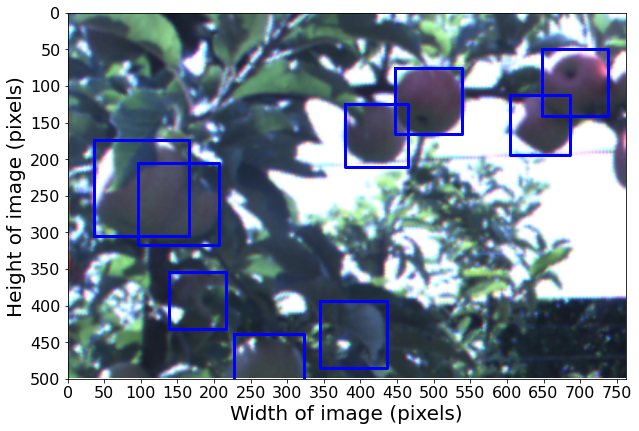

In [35]:
plot_img_and_annots(Is_test_sc[img_idx], annots_test_sc[img_idx], True)

The proposals that follow from the RPN are shown below.

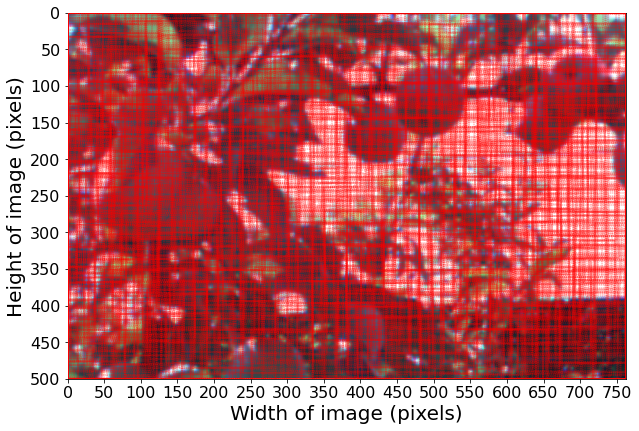

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(Is_test_sc[img_idx], zorder=-10)
for proposal in fasterrcnn.rpn_output_:
    rectangle_points = np.array([[proposal[0], proposal[1], proposal[1], proposal[0], proposal[0]],
                                 [proposal[2], proposal[2], proposal[3], proposal[3], proposal[2]]])
    plt.plot(rectangle_points[0,:], rectangle_points[1,:], color='red', linestyle='dashed', linewidth=0.4, zorder=10)
plt.xlabel('Width of image (pixels)', fontsize=20)
plt.ylabel('Height of image (pixels)', fontsize=20)
plt.xticks(np.linspace(0, 750, 16), fontsize=16)
plt.yticks(np.linspace(0, 500, 11), fontsize=16)
plt.xlim(0, 762)
plt.ylim(500, 0)        
plt.show()

The boxes that are classified as apple by the FRCNN are shown below.

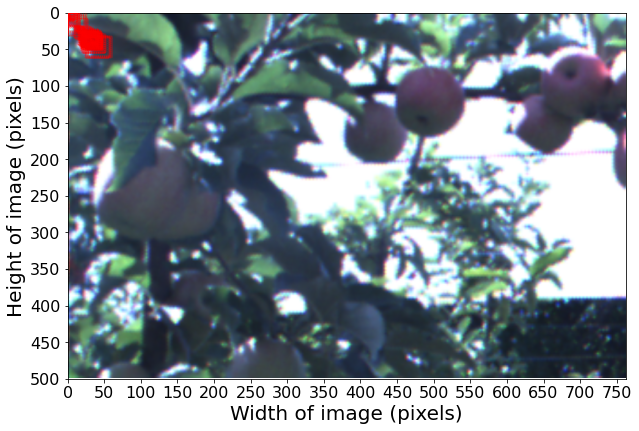

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(Is_test_sc[img_idx], zorder=-10)
for proposal in fasterrcnn.frcnn_output_:
    rectangle_points = np.array([[proposal[0], proposal[1], proposal[1], proposal[0], proposal[0]],
                                 [proposal[2], proposal[2], proposal[3], proposal[3], proposal[2]]])
    plt.plot(rectangle_points[0,:], rectangle_points[1,:], color='red', linestyle='dashed', linewidth=0.4, zorder=10)
plt.xlabel('Width of image (pixels)', fontsize=20)
plt.ylabel('Height of image (pixels)', fontsize=20)
plt.xticks(np.linspace(0, 750, 16), fontsize=16)
plt.yticks(np.linspace(0, 500, 11), fontsize=16)
plt.xlim(0, 762)
plt.ylim(500, 0)        
plt.show()

The final output of the Faster R-CNN is shown below.

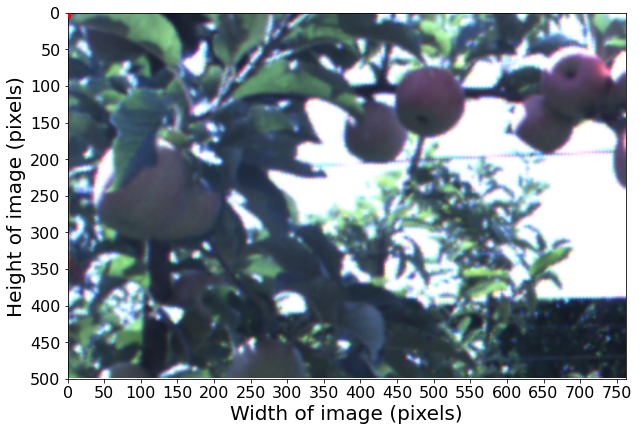

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(Is_test_sc[img_idx], zorder=-10)
for detection in detections:
    rectangle_points = np.array([[detections[0], detections[1], detections[1], detections[0], detections[0]],
                                 [detections[2], detections[2], detections[3], detections[3], detections[2]]])
    plt.plot(rectangle_points[0,:], rectangle_points[1,:], color='red', linestyle='dashed', linewidth=0.4, zorder=10)
plt.xlabel('Width of image (pixels)', fontsize=20)
plt.ylabel('Height of image (pixels)', fontsize=20)
plt.xticks(np.linspace(0, 750, 16), fontsize=16)
plt.yticks(np.linspace(0, 500, 11), fontsize=16)
plt.xlim(0, 762)
plt.ylim(500, 0)        
plt.show()